<a href="https://colab.research.google.com/github/Liekos97/CS-1101-MU/blob/master/MajorProject_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install split-folders
!pip install split-folders tqdm

In [ ]:
from numpy.random import seed
seed(121)
import tensorflow as tf
tf.random.set_seed(212)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
#import splitfolders
import datetime

In [ ]:
#image preprocessing

#main_dir="/content/drive/MyDrive/Datasets/PlantVillageReduced"
output_dir="/content/drive/MyDrive/Datasets/ReducedOutput2"
#splitfolders.ratio(main_dir,output=output_dir,seed=133,ratio=(.7,.2,.1))

In [ ]:
val_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,
                                                              rotation_range=20,
                                                              width_shift_range=0.2,
                                                              height_shift_range=0.2,
                                                              vertical_flip=True,
                                                              horizontal_flip=True)
training_set=train_datagen.flow_from_directory(output_dir+'/train',target_size=(256,256),class_mode='categorical',batch_size=16,shuffle=True)
validation_set=val_datagen.flow_from_directory(output_dir+'/val',target_size=(256,256),class_mode='categorical',batch_size=16,shuffle=False)
test_set=val_datagen.flow_from_directory(output_dir+'/test',target_size=(256,256),class_mode='categorical',batch_size=8,shuffle=False)

Found 8394 images belonging to 11 classes.
Found 2397 images belonging to 11 classes.
Found 1202 images belonging to 11 classes.


In [ ]:
#classifier model
#linear inception models 

inputs=tf.keras.Input(shape=(256,256,3))

x=tf.keras.layers.SeparableConv2D(96,(3,3),padding='valid',dilation_rate=3,activation='relu')(inputs)
x=tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same')(x)
x=tf.keras.layers.SeparableConv2D(128,(3,3),padding='valid',dilation_rate=2,activation='relu')(x)
x=tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same')(x)
x=tf.keras.layers.SeparableConv2D(196,(3,3),padding='valid',activation='relu')(x)
x=tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='valid')(x)
x=tf.keras.layers.BatchNormalization()(x) 

#inception module 1
conv1=tf.keras.layers.Conv2D(64,(1,1),padding='same',activation='relu')(x)

conv3=tf.keras.layers.Conv2D(48,(1,1),padding='same',activation='relu')(x)
conv3=tf.keras.layers.Conv2D(64,(3,1),padding='same',activation='relu')(conv3)
conv3=tf.keras.layers.Conv2D(64,(1,3),padding='same',activation='relu')(conv3)

conv5=tf.keras.layers.Conv2D(48,(1,1),padding='same',activation='relu')(x)
conv5=tf.keras.layers.Conv2D(64,(3,1),padding='same',activation='relu')(conv5)
conv5=tf.keras.layers.Conv2D(64,(1,3),padding='same',activation='relu')(conv5)
mid1=tf.keras.layers.Conv2D(64,(3,1),padding='same',activation='relu')(conv5)
mid2=tf.keras.layers.Conv2D(64,(1,3),padding='same',activation='relu')(conv5)
conv5=tf.keras.layers.Concatenate()([mid1,mid2])

pool=tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(1,1),padding='same')(x)
pool=tf.keras.layers.Conv2D(64,(1,1),padding='same',activation='relu')(pool)

conc1=tf.keras.layers.Concatenate()([conv1,conv3,conv5,pool])
x=tf.keras.layers.Concatenate()([x,conc1])

#inception module 2
conv21=tf.keras.layers.Conv2D(64,(1,1),padding='same',activation='relu')(x)

conv23=tf.keras.layers.Conv2D(48,(1,1),padding='same',activation='relu')(x)
conv23=tf.keras.layers.Conv2D(64,(3,1),padding='same',activation='relu')(conv23)
conv23=tf.keras.layers.Conv2D(64,(1,3),padding='same',activation='relu')(conv23)

conv25=tf.keras.layers.Conv2D(48,(1,1),padding='same',activation='relu')(x)
conv25=tf.keras.layers.Conv2D(64,(3,1),padding='same',activation='relu')(conv25)
conv25=tf.keras.layers.Conv2D(64,(1,3),padding='same',activation='relu')(conv25)
mid3=tf.keras.layers.Conv2D(64,(3,1),padding='same',activation='relu')(conv25)
mid4=tf.keras.layers.Conv2D(64,(1,3),padding='same',activation='relu')(conv25)
conv25=tf.keras.layers.Concatenate()([mid3,mid4])

pool2=tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(1,1),padding='same')(x)
pool2=tf.keras.layers.Conv2D(64,(1,1),padding='same',activation='relu')(pool2)

conc2=tf.keras.layers.Concatenate()([conv21,conv23,conv25,pool2])
x=tf.keras.layers.Concatenate()([x,conc2])

x=tf.keras.layers.GlobalAveragePooling2D()(x)
outputs=tf.keras.layers.Dense(11,activation='softmax')(x)

model=tf.keras.Model(inputs=inputs,outputs=outputs)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 250, 250, 96) 411         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 125, 125, 96) 0           separable_conv2d[0][0]           
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 121, 121, 128 13280       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:
#compile

model.compile(optimizer=tf.keras.optimizers.Adam(amsgrad=True),loss='CategoricalCrossentropy',metrics=['accuracy'])

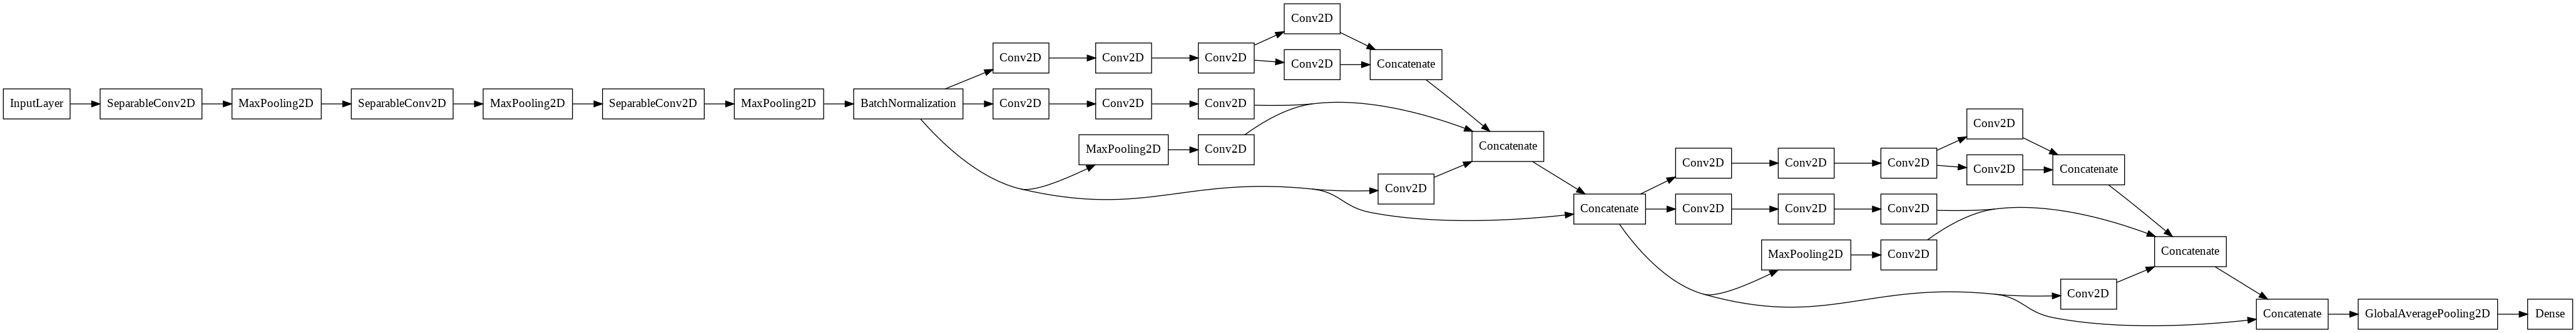

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=False,show_layer_names=False,rankdir='LR',dpi=96)

In [ ]:
#callbacks

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Checkpoints/MC/savedmodel.{epoch:02d}-{val_accuracy:.2f}.hdf5',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)

logdir="/content/drive/MyDrive/Checkpoints/TB/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1,write_graph=False)

In [ ]:
#previous log clearance

rm -rf /content/drive/MyDrive/Checkpoints/TB/logs/

In [ ]:
#training 

history=model.fit(x=training_set,epochs=30,verbose=1,validation_data=validation_set,shuffle=True,callbacks=checkpoint_callback)

Epoch 1/30
597/597 [==============================] - 6017s 10s/step - loss: 1.7669 - accuracy: 0.3671 - val_loss: 1.3675 - val_accuracy: 0.5385

Epoch 00001: val_accuracy improved from -inf to 0.53852, saving model to /content/drive/MyDrive/Checkpoints/MC/savedmodel.01-0.54.hdf5
Epoch 2/30
597/597 [==============================] - 249s 417ms/step - loss: 1.0640 - accuracy: 0.6230 - val_loss: 1.4184 - val_accuracy: 0.5693

Epoch 00002: val_accuracy improved from 0.53852 to 0.56933, saving model to /content/drive/MyDrive/Checkpoints/MC/savedmodel.02-0.57.hdf5
Epoch 3/30
597/597 [==============================] - 247s 414ms/step - loss: 0.7269 - accuracy: 0.7447 - val_loss: 0.8314 - val_accuracy: 0.7128

Epoch 00003: val_accuracy improved from 0.56933 to 0.71277, saving model to /content/drive/MyDrive/Checkpoints/MC/savedmodel.03-0.71.hdf5
Epoch 4/30
597/597 [==============================] - 249s 416ms/step - loss: 0.4899 - accuracy: 0.8202 - val_loss: 0.3887 - val_accuracy: 0.8514

Ep

In [ ]:
#validation evaluation

validation_set.reset()
model.evaluate(x=validation_set,verbose=1)

171/171 [==============================] - 15s 87ms/step - loss: 0.0881 - accuracy: 0.9674


[0.0881098061800003, 0.9673514366149902]

In [ ]:
#test set evaluation

model.evaluate(x=test_set,verbose=1)

171/171 [==============================] - 623s 4s/step - loss: 0.0750 - accuracy: 0.9773


[0.07495158165693283, 0.9773225784301758]

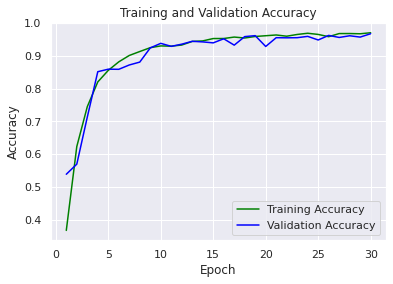

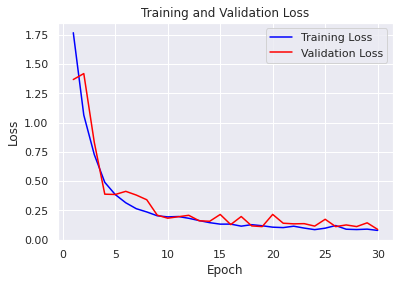

In [ ]:
#visual representation

sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

#loss plot
plt.plot(epochs, loss, color='blue', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/Checkpoints/TB/logs

In [ ]:
# predicting single image

from keras.preprocessing import image
import numpy as np
image_path = ""
new_img = image.load_img(image_path, target_size=(256, 256))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = model.predict(img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]

#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()

In [ ]:
# reset the test_data to start iterating over dataset from scratch
test_set.reset()

# start to predict
pred = model.predict(test_set)

In [ ]:
# use the confusion_matrix function provided by tensorflow to generate confusion matrix
con_mat = tf.math.confusion_matrix(labels=test_set.classes, predictions=np.argmax(pred, axis=1)).numpy()

# normalize the confusion matrix
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

# convert the nomalized confusion matrix for better view
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = test_set.class_indices.keys(), 
                     columns = test_set.class_indices.keys())

# show the nomalized confusion matrix
con_mat_df

,Corn___Cercospora_leaf_spot Gray_leaf_spot,Corn___Common_rust,Corn___Northern_Leaf_Blight,Corn___healthy,Grape___Black_rot,Grape___Esca_(Black_Measles),Grape___Leaf_blight_(Isariopsis_Leaf_Spot),Grape___healthy,Potato___Early_blight,Potato___Late_blight,Potato___healthy
Corn___Cercospora_leaf_spot Gray_leaf_spot,0.93,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Corn___Common_rust,0.00,0.98,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00
Corn___Northern_Leaf_Blight,0.06,0.00,0.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Corn___healthy,0.00,0.00,0.00,0.99,0.00,0.00,0.00,0.00,0.00,0.00,0.01
Grape___Black_rot,0.00,0.00,0.00,0.00,0.95,0.04,0.00,0.01,0.00,0.00,0.00
Grape___Esca_(Black_Measles),0.00,0.00,0.00,0.00,0.01,0.99,0.00,0.00,0.00,0.00,0.00
Grape___Leaf_blight_(Isariopsis_Leaf_Spot),0.00,0.00,0.00,0.00,0.00,0.00,0.99,0.00,0.01,0.00,0.00
Grape___healthy,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.99,0.00,0.00,0.01
Potato___Early_blight,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
Potato___Late_blight,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.06,0.88,0.04


In [ ]:
# convert the original confusion matrix for better view (using the case numbers)
con_mat_df_explain = pd.DataFrame(con_mat,
                     index = test_set.class_indices.keys(), 
                     columns = test_set.class_indices.keys())

# show the unnomalized confusion matrix
con_mat_df_explain

,Corn___Cercospora_leaf_spot Gray_leaf_spot,Corn___Common_rust,Corn___Northern_Leaf_Blight,Corn___healthy,Grape___Black_rot,Grape___Esca_(Black_Measles),Grape___Leaf_blight_(Isariopsis_Leaf_Spot),Grape___healthy,Potato___Early_blight,Potato___Late_blight,Potato___healthy
Corn___Cercospora_leaf_spot Gray_leaf_spot,93,0,7,0,0,0,0,0,0,0,0
Corn___Common_rust,0,117,0,0,0,0,0,0,3,0,0
Corn___Northern_Leaf_Blight,6,0,94,0,0,0,0,0,0,0,0
Corn___healthy,0,0,0,116,0,0,0,0,0,0,1
Grape___Black_rot,0,0,0,0,112,5,0,1,0,0,0
Grape___Esca_(Black_Measles),0,0,0,0,1,138,0,0,0,0,0
Grape___Leaf_blight_(Isariopsis_Leaf_Spot),0,0,0,0,0,0,107,0,1,0,0
Grape___healthy,0,0,0,0,0,0,0,99,0,0,1
Potato___Early_blight,0,0,0,0,0,0,0,0,100,0,0
Potato___Late_blight,0,0,0,0,0,0,2,0,6,88,4


In [ ]:
import sklearn.metrics
# generate the clasification report by using the classification_report of sklearn package
report = sklearn.metrics.classification_report(test_set.classes, np.argmax(pred, axis=1), target_names=validation_set.class_indices.keys())

# print the report
print(report)

                                            precision    recall  f1-score   support

Corn___Cercospora_leaf_spot Gray_leaf_spot       0.94      0.93      0.93       100
                        Corn___Common_rust       1.00      0.97      0.99       120
               Corn___Northern_Leaf_Blight       0.93      0.94      0.94       100
                            Corn___healthy       1.00      0.99      1.00       117
                         Grape___Black_rot       0.99      0.95      0.97       118
              Grape___Esca_(Black_Measles)       0.97      0.99      0.98       139
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.98      0.99      0.99       108
                           Grape___healthy       0.99      0.99      0.99       100
                     Potato___Early_blight       0.91      1.00      0.95       100
                      Potato___Late_blight       1.00      0.88      0.94       100
                          Potato___healthy       0.94      1.00      0.97  